## Tarea 3 - Métodos de Aprendizajes de Máquinas en Data Science

### Integrantes: Sofía Álvarez, Sebastián Dinator.

### Importación de librerías y datos

In [3]:
import pandas as pd
import numpy as np
from sympy import Matrix
import re
import string
import emoji

from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer

# k-fold cross validation
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold

# Modelos
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics as mt

In [4]:
# Se cargan los datos
train_data = pd.read_csv('train_tweets.csv') # Entrenamiento
test_data = pd.read_csv('test_tweets.csv') # Clasificar

In [5]:
# Mostrando la data
display(train_data.head(6))
print(train_data.shape)
print('# id =', len(train_data['tweet_id'].unique()))

display(test_data.head(6))
print(test_data.shape)
print('# id =', len(test_data['tweet_id'].unique()))



,tweet_id,text,Odio
0,1399516036240662528,En una amistad o soy tipo: \r\nLo peor es que ...,0
1,1320788179721560065,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA...,1
2,1079889645280944129,menos mal q se recibe el año con ropa blanca j...,0
3,1369254390134145033,Cuantos INFILTRADOS extranjeros hay ahi😡 https...,1
4,1533854824378290176,#ENCONTRADO #GUAYAQUIL\r\nFecha: 06/06/22\r\nS...,0
5,1233127781707333632,Ana Maraca culia #Los80,1


(2256, 3)
# id = 2256


,tweet_id,text
0,1533854540763742209,Estoy de acuerdo que corrijas a tus hijos pero...
1,1277756504519725057,@danieljadue @ArquitectsPC1 Te regalo un pico ...
2,1529500412402757632,@Nnicolas_M @carolinawagner_ @i_krmns El paro ...
3,1167425893066838016,"@vroteberde Estoy en la misma, hoy no laburo c..."
4,1399515878727749632,@beudalgoaj puta merda
5,1533854418835189760,@aitana_atenea Puto hermoso cuerpazo 🤗🥰👌🏼


(2291, 2)
# id = 2291


In [6]:
# Analizando la variable Odio
train_data['Odio'].unique()

array([0, 1])

### Limpieza de datos

In [7]:
# Eliminando emojis
train_data['text'] = train_data['text'].apply(lambda s: emoji.replace_emoji(s, ''))
display(train_data.head(6))

test_data['text'] = test_data['text'].apply(lambda s: emoji.replace_emoji(s, ''))
display(test_data.head(6))

,tweet_id,text,Odio
0,1399516036240662528,En una amistad o soy tipo: \r\nLo peor es que ...,0
1,1320788179721560065,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA...,1
2,1079889645280944129,menos mal q se recibe el año con ropa blanca j...,0
3,1369254390134145033,Cuantos INFILTRADOS extranjeros hay ahi https:...,1
4,1533854824378290176,#ENCONTRADO #GUAYAQUIL\r\nFecha: 06/06/22\r\nS...,0
5,1233127781707333632,Ana Maraca culia #Los80,1


,tweet_id,text
0,1533854540763742209,Estoy de acuerdo que corrijas a tus hijos pero...
1,1277756504519725057,@danieljadue @ArquitectsPC1 Te regalo un pico ...
2,1529500412402757632,@Nnicolas_M @carolinawagner_ @i_krmns El paro ...
3,1167425893066838016,"@vroteberde Estoy en la misma, hoy no laburo c..."
4,1399515878727749632,@beudalgoaj puta merda
5,1533854418835189760,@aitana_atenea Puto hermoso cuerpazo


In [8]:
# Función para limpiar los tweets
def clean_tweet(tweet):
    #tweet = tweet.lower() # Convertir a minúsculas (dejar??)
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE) # Eliminar URLs
    tweet = re.sub(r'@\w+', '', tweet) # Eliminar menciones de usuario
    tweet = re.sub(r'#\w+', '', tweet) # Eliminar hashtags
    tweet = re.sub(r'\d+', '', tweet) # Eliminar números
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) # Eliminar puntuaciones
    tweet = re.sub(r'\\r\\n|\\n|\\r', ' ', tweet) # Eliminar caracteres especiales
    tweet = re.sub(r'\s+', ' ', tweet).strip() # Eliminar espacios adicionales
    tweet = re.sub(r'[¿¡]', '', tweet) # Eliminar ¿ y ¡
    
    return tweet

In [9]:
# Aplicando función de limpieza
train_data['cleaned_text'] = train_data['text'].apply(clean_tweet)
test_data['cleaned_text'] = test_data['text'].apply(clean_tweet)

display(test_data.head(6))
display(test_data.head(6))

,tweet_id,text,cleaned_text
0,1533854540763742209,Estoy de acuerdo que corrijas a tus hijos pero...,Estoy de acuerdo que corrijas a tus hijos pero...
1,1277756504519725057,@danieljadue @ArquitectsPC1 Te regalo un pico ...,Te regalo un pico pa que lleguis de poto wn hueco
2,1529500412402757632,@Nnicolas_M @carolinawagner_ @i_krmns El paro ...,El paro de camineros no tiene nada que ver con...
3,1167425893066838016,"@vroteberde Estoy en la misma, hoy no laburo c...",Estoy en la misma hoy no laburo como buen plan...
4,1399515878727749632,@beudalgoaj puta merda,puta merda
5,1533854418835189760,@aitana_atenea Puto hermoso cuerpazo,Puto hermoso cuerpazo


,tweet_id,text,cleaned_text
0,1533854540763742209,Estoy de acuerdo que corrijas a tus hijos pero...,Estoy de acuerdo que corrijas a tus hijos pero...
1,1277756504519725057,@danieljadue @ArquitectsPC1 Te regalo un pico ...,Te regalo un pico pa que lleguis de poto wn hueco
2,1529500412402757632,@Nnicolas_M @carolinawagner_ @i_krmns El paro ...,El paro de camineros no tiene nada que ver con...
3,1167425893066838016,"@vroteberde Estoy en la misma, hoy no laburo c...",Estoy en la misma hoy no laburo como buen plan...
4,1399515878727749632,@beudalgoaj puta merda,puta merda
5,1533854418835189760,@aitana_atenea Puto hermoso cuerpazo,Puto hermoso cuerpazo


In [10]:
# Revidando que no queden símbolos
for i in train_data['cleaned_text']:
    if len(re.compile(r'[?¿@#¡!/\&$%]').findall(i)) > 0:
        print(i)
        
for i in test_data['cleaned_text']:
    if len(re.compile(r'[?¿@#¡!/\&$%]').findall(i)) > 0:
        print(i)

In [11]:
# FALTA EXPLICAR

tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_data.iloc[:, 3])
print(X_train.shape)

y_train = train_data.iloc[:,2]
print(y_train.shape)

(2256, 9899)
(2256,)


In [35]:
# Función para generar k-fold y calcular F1-score total del modelo

def kfold(modelo):
    for K in range(4,6,1):  # Se decide probar con dos valores de K. 
                            # K = 4 -> split 75% - 25% (451 datos)
                            # K = 5 -> split 80% - 20% (564 datos)
                
        resultado = cross_val_score(modelo, X_train, y_train, cv = K, scoring='f1') 
        print(f'K = {K}: {np.mean(resultado):.3f} +- {np.std(resultado):.3f}')
    return float(np.mean(resultado))


# SVM

### Para escoger el mejor modelo de Support Vector Machine, primero se analizarán todos los tipos de kernel para saber cuál se ajusta a los datos y 2 valores extremos de C.

#### Considerando el dilema sesgo-varianza, se espera que los modelos con C = 999 (modelo complejo) tengan mejor F1-score que los C = 1 (modelo sencillo).

In [13]:
for tipo in ['linear', 'poly', 'rbf', 'sigmoid']:
    for c in [1, 999]: #, 1, 10, 999]:
        print(f"Modelo: kernel {tipo.upper()} y C = {c}")
            
        SVM = SVC(C = c, kernel = tipo, random_state = 8) # Creando modelo
        kfold(SVM) # Entrenando
        
        print('')    
    print('----------')

Modelo: kernel LINEAR y C = 1
K = 4: 0.782 +- 0.012
K = 5: 0.783 +- 0.013

Modelo: kernel LINEAR y C = 999
K = 4: 0.745 +- 0.026
K = 5: 0.735 +- 0.019

----------
Modelo: kernel POLY y C = 1
K = 4: 0.736 +- 0.002
K = 5: 0.738 +- 0.003

Modelo: kernel POLY y C = 999
K = 4: 0.737 +- 0.005
K = 5: 0.739 +- 0.006

----------
Modelo: kernel RBF y C = 1
K = 4: 0.783 +- 0.005
K = 5: 0.783 +- 0.010

Modelo: kernel RBF y C = 999
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012

----------
Modelo: kernel SIGMOID y C = 1
K = 4: 0.782 +- 0.011
K = 5: 0.782 +- 0.014

Modelo: kernel SIGMOID y C = 999
K = 4: 0.674 +- 0.015
K = 5: 0.686 +- 0.029

----------


#### Kernel poly para ambos C tuvo el f1-score más bajo así que se descarta.
#### Luego, tanto linear como sigmoid empeoraron su rendimiento con un C alto, de esto se infiere que los kernel no son adecados para aprender el ser de datos.
#### Finalmente, kernel rbf cumple con el dilema sesgo-varianza. Además, para cada C los resultados son similares, si bien la diferencia de data no es extremadamente significativa, porque solo se está cambiando K, da a entender que al repetir el modelo la predicción no varía en gran medida, es decir, es e kernel que más generaliza.

### Por lo tanto, ahora se probará kernel radiobasal con distintos valores de C.

In [14]:
for c in [0.1, 1, 10, 70, 500, 999]:
    print(f"Modelo: kernel RBF y C = {c}")

    SVM = SVC(C = c, kernel = 'rbf', random_state = 8) # Creando modelo
    kfold(SVM) # Entrenando

    print('')    


Modelo: kernel RBF y C = 0.1
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: kernel RBF y C = 1
K = 4: 0.783 +- 0.005
K = 5: 0.783 +- 0.010

Modelo: kernel RBF y C = 10
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012

Modelo: kernel RBF y C = 70
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012

Modelo: kernel RBF y C = 500
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012

Modelo: kernel RBF y C = 999
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012



In [15]:
# ME TINCA UN VALOR INTERMEDIO DE C, PARA BALANCEAR SESGO Y VARIANZA, EL C = 70

### Como se observa, con C > 10 el score se estabiliza, así que se va a analizar 1 < C < 10:

In [16]:
for c in range(2,10,1):
    print(f"Modelo: kernel RBF y C = {c}")

    SVM = SVC(C = c, kernel = 'rbf', random_state = 8) # Creando modelo
    kfold(SVM) # Entrenando

    print('')    

Modelo: kernel RBF y C = 2
K = 4: 0.792 +- 0.003
K = 5: 0.788 +- 0.010

Modelo: kernel RBF y C = 3
K = 4: 0.793 +- 0.004
K = 5: 0.792 +- 0.013

Modelo: kernel RBF y C = 4
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012

Modelo: kernel RBF y C = 5
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012

Modelo: kernel RBF y C = 6
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012

Modelo: kernel RBF y C = 7
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012

Modelo: kernel RBF y C = 8
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012

Modelo: kernel RBF y C = 9
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012



In [17]:
### FALTA CONCLUIR

# Naive Bayes
### Se entrenarán modelos de NB con distintos valores de alpha:

In [18]:
for alpha in [0.1, 0.5, 1, 2, 5, 10, 60, 100]:
    print(f"Modelo: alpha = {alpha}")
        
    NB = MultinomialNB(alpha = alpha) # Creando modelo
    kfold(NB) # Entrenando
            
    print('')
    
    
    


Modelo: alpha = 0.1
K = 4: 0.793 +- 0.006
K = 5: 0.788 +- 0.011

Modelo: alpha = 0.5
K = 4: 0.791 +- 0.009
K = 5: 0.792 +- 0.010

Modelo: alpha = 1
K = 4: 0.774 +- 0.004
K = 5: 0.778 +- 0.008

Modelo: alpha = 2
K = 4: 0.750 +- 0.003
K = 5: 0.753 +- 0.004

Modelo: alpha = 5
K = 4: 0.738 +- 0.003
K = 5: 0.738 +- 0.003

Modelo: alpha = 10
K = 4: 0.734 +- 0.001
K = 5: 0.734 +- 0.002

Modelo: alpha = 60
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: alpha = 100
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001



### Se estabiliza luego de de alpha = 2, por lo que se evalúa entre 0.1 y 2.

In [31]:
for alpha in range(1, 20, 1):
    alpha = alpha / 10.0
    print(f"Modelo: alpha = {alpha}")
        
    NB = MultinomialNB(alpha = alpha)
    kfold(NB)  # Entrenando
            
    print('')

Modelo: alpha = 0.1
K = 4: 0.793 +- 0.006
K = 5: 0.788 +- 0.011

Modelo: alpha = 0.2
K = 4: 0.798 +- 0.008
K = 5: 0.788 +- 0.010

Modelo: alpha = 0.3
K = 4: 0.797 +- 0.011
K = 5: 0.791 +- 0.009

Modelo: alpha = 0.4
K = 4: 0.795 +- 0.011
K = 5: 0.793 +- 0.012

Modelo: alpha = 0.5
K = 4: 0.791 +- 0.009
K = 5: 0.792 +- 0.010

Modelo: alpha = 0.6
K = 4: 0.788 +- 0.012
K = 5: 0.788 +- 0.014

Modelo: alpha = 0.7
K = 4: 0.788 +- 0.011
K = 5: 0.785 +- 0.014

Modelo: alpha = 0.8
K = 4: 0.784 +- 0.010
K = 5: 0.783 +- 0.011

Modelo: alpha = 0.9
K = 4: 0.778 +- 0.006
K = 5: 0.782 +- 0.010

Modelo: alpha = 1.0
K = 4: 0.774 +- 0.004
K = 5: 0.778 +- 0.008

Modelo: alpha = 1.1
K = 4: 0.772 +- 0.003
K = 5: 0.773 +- 0.007

Modelo: alpha = 1.2
K = 4: 0.767 +- 0.002
K = 5: 0.770 +- 0.007

Modelo: alpha = 1.3
K = 4: 0.763 +- 0.002
K = 5: 0.767 +- 0.007

Modelo: alpha = 1.4
K = 4: 0.760 +- 0.002
K = 5: 0.762 +- 0.006

Modelo: alpha = 1.5
K = 4: 0.758 +- 0.003
K = 5: 0.759 +- 0.006

Modelo: alpha = 1.6
K = 4

In [ ]:
# Concluir

# Ensamblados

## Bagging Random Forest

In [20]:
for criterio in ['gini', 'entropy']:
    for NE in [20, 100, 500]:
        print(f'Modelo: {criterio.upper()}, NE = {NE}')
        RFC = RandomForestClassifier(n_estimators = NE, criterion = criterio, n_jobs=-1, random_state=8) 
        kfold(RFC) 
        
        print()
    print('---------')
        

Modelo: GINI, NE = 20
K = 4: 0.768 +- 0.019
K = 5: 0.755 +- 0.009

Modelo: GINI, NE = 100
K = 4: 0.780 +- 0.014
K = 5: 0.783 +- 0.012

Modelo: GINI, NE = 500
K = 4: 0.786 +- 0.014
K = 5: 0.789 +- 0.015

---------
Modelo: ENTROPY, NE = 20
K = 4: 0.760 +- 0.008
K = 5: 0.773 +- 0.012

Modelo: ENTROPY, NE = 100
K = 4: 0.788 +- 0.012
K = 5: 0.789 +- 0.017

Modelo: ENTROPY, NE = 500
K = 4: 0.789 +- 0.010
K = 5: 0.795 +- 0.021

---------


In [21]:
# AJUSTAR MAX DEPTH y NE

for NE in [5, 10, 20, 50, 70]:
    print(f'Modelo: NE = {NE}')
    RFC = RandomForestClassifier(n_estimators = NE, max_depth = None, criterion = 'entropy', n_jobs=-1, random_state = 8)
    kfold(RFC)

    print('')
    
    


Modelo: NE = 5
K = 4: 0.730 +- 0.015
K = 5: 0.739 +- 0.012

Modelo: NE = 10
K = 4: 0.747 +- 0.008
K = 5: 0.748 +- 0.008

Modelo: NE = 20
K = 4: 0.760 +- 0.008
K = 5: 0.773 +- 0.012

Modelo: NE = 50
K = 4: 0.777 +- 0.007
K = 5: 0.787 +- 0.012

Modelo: NE = 70
K = 4: 0.783 +- 0.013
K = 5: 0.790 +- 0.009



Modelo: NE = 5
K = 4: 0.730 +- 0.015
K = 5: 0.739 +- 0.012
Modelo: NE = 10
K = 4: 0.747 +- 0.008
K = 5: 0.748 +- 0.008
Modelo: NE = 15
K = 4: 0.768 +- 0.009
K = 5: 0.772 +- 0.021
Modelo: NE = 20
K = 4: 0.760 +- 0.008
K = 5: 0.773 +- 0.012
Modelo: NE = 25
K = 4: 0.770 +- 0.006
K = 5: 0.776 +- 0.009
Modelo: NE = 30
K = 4: 0.770 +- 0.001
K = 5: 0.781 +- 0.009
Modelo: NE = 35
K = 4: 0.770 +- 0.003
K = 5: 0.781 +- 0.017
Modelo: NE = 40
K = 4: 0.773 +- 0.002
K = 5: 0.783 +- 0.013
Modelo: NE = 45
K = 4: 0.775 +- 0.007
K = 5: 0.780 +- 0.016
Modelo: NE = 50
K = 4: 0.777 +- 0.007
K = 5: 0.787 +- 0.012
Modelo: NE = 55
K = 4: 0.782 +- 0.009
K = 5: 0.786 +- 0.010
Modelo: NE = 60
K = 4: 0.778 +- 0.009
K = 5: 0.788 +- 0.008
Modelo: NE = 65
K = 4: 0.788 +- 0.014
K = 5: 0.791 +- 0.009
Modelo: NE = 70
K = 4: 0.783 +- 0.013
K = 5: 0.790 +- 0.009
Modelo: NE = 75
K = 4: 0.785 +- 0.012
K = 5: 0.791 +- 0.013
Modelo: NE = 80
K = 4: 0.785 +- 0.011
K = 5: 0.793 +- 0.014
Modelo: NE = 85
K = 4: 0.786 +- 0.013
K =

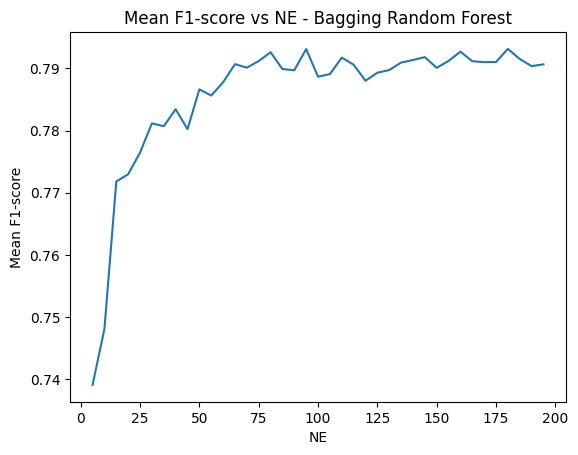

In [40]:
import matplotlib.pyplot as plt

NE_values = range(5, 200, 5)

mean_scores = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
    RFC = RandomForestClassifier(n_estimators = NE, max_depth = None, criterion = 'entropy', n_jobs=-1, random_state = 8)
    V = kfold(RFC)
    mean_score = V
    mean_scores.append(mean_score)

plt.plot(NE_values, mean_scores)
plt.xlabel('NE')
plt.ylabel('Mean F1-score')
plt.title('Mean F1-score vs NE - Bagging Random Forest')
plt.show()


In [ ]:
# Por 75 se estabiliza?

## Bagging de NV

In [22]:
# AJUSTAR ALPHA Y NE
for NE in [5, 10, 20, 50, 70, 100]:
    
    print(f'Modelo: NE = {NE}')
    BC = BaggingClassifier(estimator = MultinomialNB(alpha = 2), n_estimators = NE, random_state = 8)
    kfold(BC)
    
    print('')

Modelo: NE = 5
K = 4: 0.752 +- 0.003
K = 5: 0.756 +- 0.005

Modelo: NE = 10
K = 4: 0.753 +- 0.003
K = 5: 0.755 +- 0.005

Modelo: NE = 20
K = 4: 0.752 +- 0.004
K = 5: 0.755 +- 0.006

Modelo: NE = 50
K = 4: 0.753 +- 0.004
K = 5: 0.754 +- 0.004

Modelo: NE = 70
K = 4: 0.751 +- 0.004
K = 5: 0.754 +- 0.005

Modelo: NE = 100
K = 4: 0.752 +- 0.003
K = 5: 0.754 +- 0.005



Modelo: NE = 5
K = 4: 0.752 +- 0.003
K = 5: 0.756 +- 0.005
Modelo: NE = 10
K = 4: 0.753 +- 0.003
K = 5: 0.755 +- 0.005
Modelo: NE = 15
K = 4: 0.751 +- 0.003
K = 5: 0.756 +- 0.005
Modelo: NE = 20
K = 4: 0.752 +- 0.004
K = 5: 0.755 +- 0.006
Modelo: NE = 25
K = 4: 0.752 +- 0.003
K = 5: 0.755 +- 0.004
Modelo: NE = 30
K = 4: 0.752 +- 0.003
K = 5: 0.755 +- 0.004
Modelo: NE = 35
K = 4: 0.753 +- 0.004
K = 5: 0.755 +- 0.004
Modelo: NE = 40
K = 4: 0.753 +- 0.004
K = 5: 0.755 +- 0.004
Modelo: NE = 45
K = 4: 0.753 +- 0.004
K = 5: 0.755 +- 0.004
Modelo: NE = 50
K = 4: 0.753 +- 0.004
K = 5: 0.754 +- 0.004
Modelo: NE = 55
K = 4: 0.752 +- 0.005
K = 5: 0.754 +- 0.004
Modelo: NE = 60
K = 4: 0.752 +- 0.005
K = 5: 0.755 +- 0.004
Modelo: NE = 65
K = 4: 0.752 +- 0.004
K = 5: 0.755 +- 0.005
Modelo: NE = 70
K = 4: 0.751 +- 0.004
K = 5: 0.754 +- 0.005
Modelo: NE = 75
K = 4: 0.751 +- 0.004
K = 5: 0.754 +- 0.005
Modelo: NE = 80
K = 4: 0.751 +- 0.003
K = 5: 0.753 +- 0.005
Modelo: NE = 85
K = 4: 0.751 +- 0.003
K =

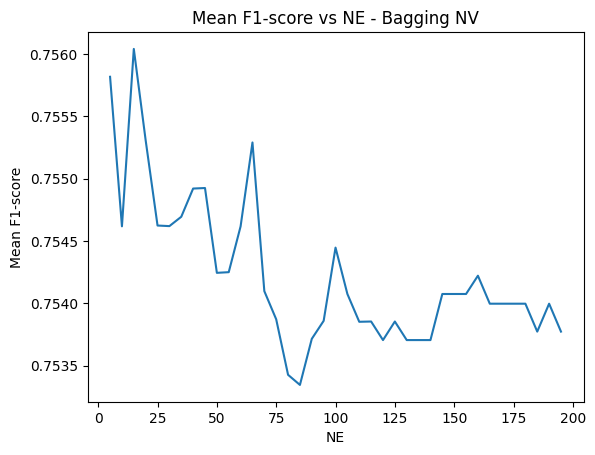

In [41]:
NE_values = range(5, 200, 5)

mean_scores = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
    BC = BaggingClassifier(estimator = MultinomialNB(alpha = 2), n_estimators = NE, random_state = 8)
    V = kfold(BC)
    mean_score = V
    mean_scores.append(mean_score)

plt.plot(NE_values, mean_scores)
plt.xlabel('NE')
plt.ylabel('Mean F1-score')
plt.title('Mean F1-score vs NE - Bagging NV')
plt.show()

## Bagging de SVM

In [23]:
# AJUSTAR C Y NE

for NE in [5, 10, 20, 50, 70, 100]:
#for c in [0.1, 1, 10, 999]:
    
    print(f'Modelo: NE = {NE}')
    BC = BaggingClassifier(estimator = SVC(C = 1, kernel = 'rbf', random_state = 8), n_estimators = NE, random_state = 8)
    kfold(BC)

    
    print('')

Modelo: NE = 5
K = 4: 0.785 +- 0.006
K = 5: 0.781 +- 0.007

Modelo: NE = 10
K = 4: 0.785 +- 0.008
K = 5: 0.782 +- 0.003

Modelo: NE = 20
K = 4: 0.789 +- 0.005
K = 5: 0.782 +- 0.004

Modelo: NE = 50
K = 4: 0.785 +- 0.004
K = 5: 0.786 +- 0.007

Modelo: NE = 70
K = 4: 0.784 +- 0.003
K = 5: 0.785 +- 0.009

Modelo: NE = 100
K = 4: 0.785 +- 0.004
K = 5: 0.787 +- 0.007



Modelo: NE = 5
K = 4: 0.785 +- 0.006
K = 5: 0.781 +- 0.007
Modelo: NE = 15
K = 4: 0.784 +- 0.006
K = 5: 0.785 +- 0.004
Modelo: NE = 25
K = 4: 0.788 +- 0.008
K = 5: 0.785 +- 0.005
Modelo: NE = 35
K = 4: 0.785 +- 0.004
K = 5: 0.783 +- 0.005
Modelo: NE = 45
K = 4: 0.784 +- 0.005
K = 5: 0.786 +- 0.007
Modelo: NE = 55
K = 4: 0.784 +- 0.005
K = 5: 0.786 +- 0.006
Modelo: NE = 65
K = 4: 0.784 +- 0.005
K = 5: 0.784 +- 0.007
Modelo: NE = 75
K = 4: 0.785 +- 0.002
K = 5: 0.785 +- 0.008
Modelo: NE = 85
K = 4: 0.785 +- 0.004
K = 5: 0.787 +- 0.007
Modelo: NE = 95
K = 4: 0.783 +- 0.005
K = 5: 0.786 +- 0.007
Modelo: NE = 105
K = 4: 0.784 +- 0.005
K = 5: 0.785 +- 0.007
Modelo: NE = 115
K = 4: 0.784 +- 0.003
K = 5: 0.784 +- 0.008
Modelo: NE = 125
K = 4: 0.784 +- 0.003
K = 5: 0.785 +- 0.009
Modelo: NE = 135
K = 4: 0.784 +- 0.003
K = 5: 0.785 +- 0.008
Modelo: NE = 145
K = 4: 0.784 +- 0.004
K = 5: 0.785 +- 0.008
Modelo: NE = 155
K = 4: 0.783 +- 0.003
K = 5: 0.785 +- 0.008
Modelo: NE = 165
K = 4: 0.782 +- 0.

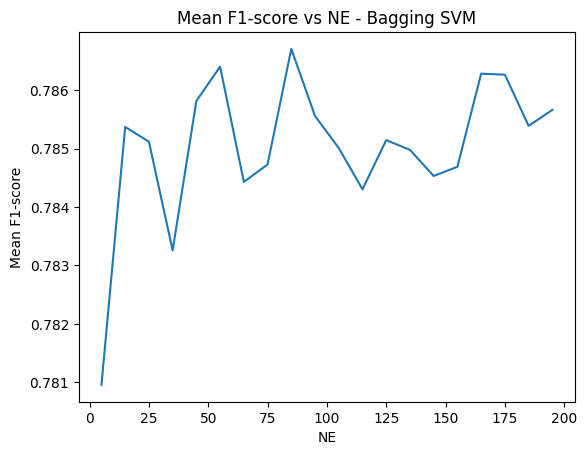

In [43]:
NE_values = range(5, 200, 10)

mean_scores = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
    BC = BaggingClassifier(estimator = SVC(C = 1, kernel = 'rbf', random_state = 8), n_estimators = NE, random_state = 8)
    V = kfold(BC)
    mean_score = V
    mean_scores.append(mean_score)

plt.plot(NE_values, mean_scores)
plt.xlabel('NE')
plt.ylabel('Mean F1-score')
plt.title('Mean F1-score vs NE - Bagging SVM')
plt.show()

## Adaboost

In [24]:
# AJUSTAR MD, NE 
for NE in [20, 100, 500]:
    print(f'Modelo: NE = {NE}')
    ABC = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = None), n_estimators = NE, random_state=8)
    kfold(ABC)
    print('')

Modelo: NE = 20
K = 4: 0.740 +- 0.010
K = 5: 0.736 +- 0.028

Modelo: NE = 100
K = 4: 0.739 +- 0.016
K = 5: 0.741 +- 0.025

Modelo: NE = 500
K = 4: 0.738 +- 0.014
K = 5: 0.739 +- 0.024



In [25]:


# AJUSTAR MD, NE 
for NE in [20, 100, 500]:
    print(f'Modelo: NE = {NE}')
    ABC = AdaBoostClassifier(estimator = MultinomialNB(alpha = 0.5), n_estimators = NE, random_state=8)
    kfold(ABC)
    print('')

Modelo: NE = 20
K = 4: 0.731 +- 0.002
K = 5: 0.731 +- 0.003

Modelo: NE = 100
K = 4: 0.757 +- 0.004
K = 5: 0.754 +- 0.008

Modelo: NE = 500
K = 4: 0.787 +- 0.005
K = 5: 0.787 +- 0.007



Modelo: NE = 5
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001
Modelo: NE = 25
K = 4: 0.731 +- 0.001
K = 5: 0.731 +- 0.002
Modelo: NE = 45
K = 4: 0.735 +- 0.004
K = 5: 0.733 +- 0.004
Modelo: NE = 65
K = 4: 0.740 +- 0.004
K = 5: 0.742 +- 0.004
Modelo: NE = 85
K = 4: 0.751 +- 0.003
K = 5: 0.747 +- 0.007
Modelo: NE = 105
K = 4: 0.758 +- 0.005
K = 5: 0.754 +- 0.008
Modelo: NE = 125
K = 4: 0.761 +- 0.004
K = 5: 0.761 +- 0.009
Modelo: NE = 145
K = 4: 0.766 +- 0.005
K = 5: 0.766 +- 0.007
Modelo: NE = 165
K = 4: 0.768 +- 0.007
K = 5: 0.769 +- 0.010
Modelo: NE = 185
K = 4: 0.771 +- 0.006
K = 5: 0.771 +- 0.010
Modelo: NE = 205
K = 4: 0.773 +- 0.004
K = 5: 0.775 +- 0.010
Modelo: NE = 225
K = 4: 0.775 +- 0.003
K = 5: 0.779 +- 0.011
Modelo: NE = 245
K = 4: 0.777 +- 0.004
K = 5: 0.779 +- 0.012
Modelo: NE = 265
K = 4: 0.780 +- 0.003
K = 5: 0.781 +- 0.011
Modelo: NE = 285
K = 4: 0.780 +- 0.001
K = 5: 0.780 +- 0.011
Modelo: NE = 305
K = 4: 0.782 +- 0.004
K = 5: 0.780 +- 0.010
Modelo: NE = 325
K = 4: 0.782 

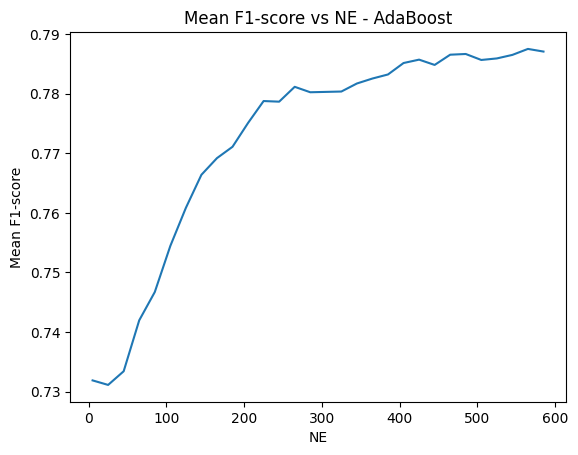

In [44]:
NE_values = range(5, 600, 20)

mean_scores = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
    ABC = AdaBoostClassifier(estimator = MultinomialNB(alpha = 0.5), n_estimators = NE, random_state=8)
    V = kfold(ABC)
    mean_score = V
    mean_scores.append(mean_score)

plt.plot(NE_values, mean_scores)
plt.xlabel('NE')
plt.ylabel('Mean F1-score')
plt.title('Mean F1-score vs NE - AdaBoost')
plt.show()

## Gradient Boosting

In [26]:

for NE in [20, 100, 500]:
    print(f'Modelo: NE = {NE}')
    GB = GradientBoostingClassifier(n_estimators = 50, random_state = 8)
    kfold(ABC)
    print('')



Modelo: NE = 20
K = 4: 0.787 +- 0.005
K = 5: 0.787 +- 0.007

Modelo: NE = 100
K = 4: 0.787 +- 0.005
K = 5: 0.787 +- 0.007

Modelo: NE = 500
K = 4: 0.787 +- 0.005
K = 5: 0.787 +- 0.007



Modelo: NE = 5
K = 4: 0.735 +- 0.003
K = 5: 0.733 +- 0.003
Modelo: NE = 25
K = 4: 0.772 +- 0.011
K = 5: 0.769 +- 0.016
Modelo: NE = 45
K = 4: 0.775 +- 0.015
K = 5: 0.778 +- 0.015
Modelo: NE = 65
K = 4: 0.774 +- 0.010
K = 5: 0.782 +- 0.018
Modelo: NE = 85
K = 4: 0.774 +- 0.011
K = 5: 0.785 +- 0.016
Modelo: NE = 105
K = 4: 0.777 +- 0.010
K = 5: 0.781 +- 0.014
Modelo: NE = 125
K = 4: 0.780 +- 0.011
K = 5: 0.780 +- 0.017
Modelo: NE = 145
K = 4: 0.781 +- 0.008
K = 5: 0.781 +- 0.016


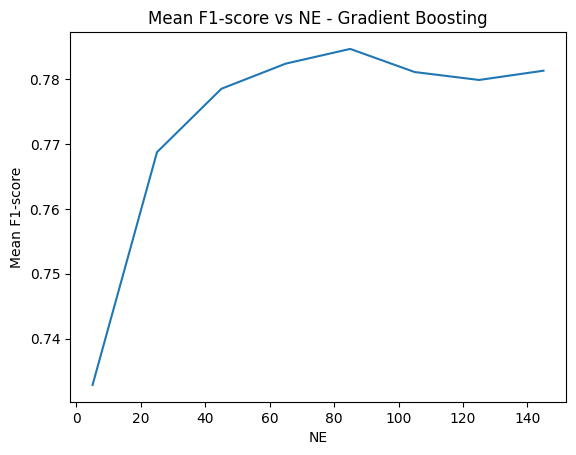

In [46]:
NE_values = range(5, 165, 20)

mean_scores = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
    GB = GradientBoostingClassifier(n_estimators = NE, random_state = 8)
    V = kfold(GB)
    mean_score = V
    mean_scores.append(mean_score)

plt.plot(NE_values, mean_scores)
plt.xlabel('NE')
plt.ylabel('Mean F1-score')
plt.title('Mean F1-score vs NE - Gradient Boosting')
plt.show()